# Try out some basic machine learning classification models for classifying emotions

In [62]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Look at the data

In [16]:
def load_face_data():
    notebook_dir = os.getcwd()
    os.chdir('../data/')
    df = pd.read_csv('icml_face_data.csv')
    os.chdir(notebook_dir)
    return df
df = load_face_data()

In [17]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


# Data cleaning

In [30]:
# strip spaces from column names and apply lower case
df = df.rename(columns={c:c.strip().lower() for c in df.columns})
print(df.columns)

Index(['emotion', 'usage', 'pixels'], dtype='object')

In [76]:
# convert pixels to array for ease in visualization and image preprocessing
def pixel_str_to_array(pixel_str):
    '''
    converts pixel as str separated by white spaces to an array
    '''
    pixel_array = np.array(pixel_str.split(), dtype=int)
    return pixel_array.reshape(48,48)

    
df['pixels_array'] = df['pixels'].apply(pixel_str_to_array)

In [58]:
# map emotion name
emotion_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
df['emotion_nm'] = df.emotion.map(emotion_map)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35887 entries, 0 to 35886
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   emotion       35887 non-null  int64 
 1   usage         35887 non-null  object
 2   pixels        35887 non-null  object
 3   pixels_array  35887 non-null  object
 4   emotion_nm    35887 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


# EDA

## Look at sample images
- 46*46 pixels
- almost straight-faced, grayscale images

Showing random sample images for Angry


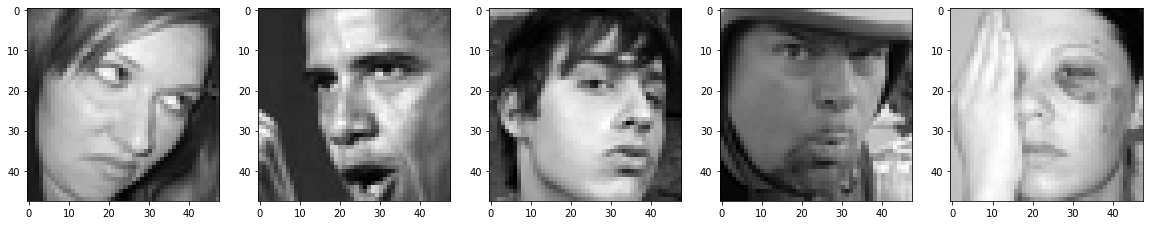

Showing random sample images for Disgust


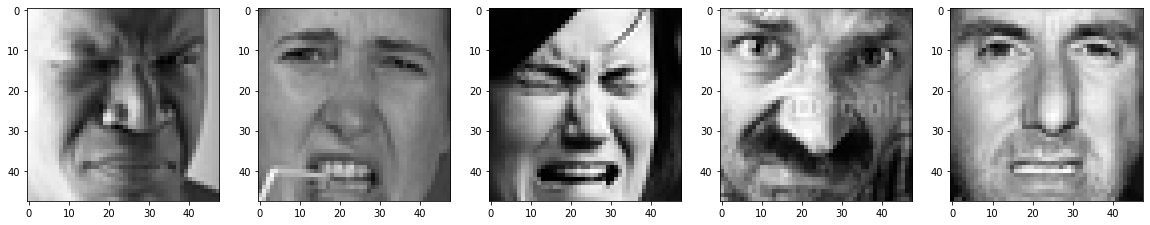

Showing random sample images for Fear


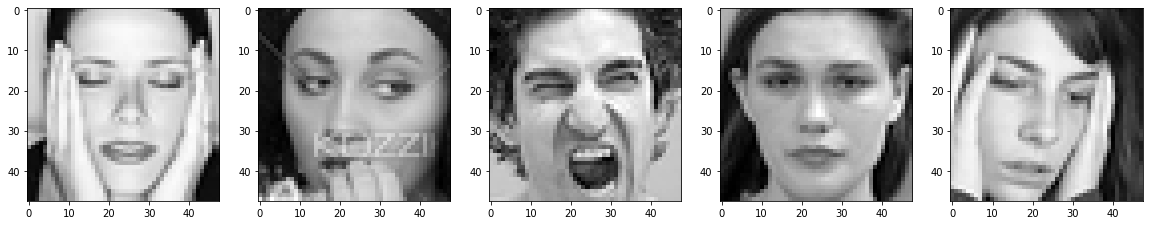

Showing random sample images for Happy


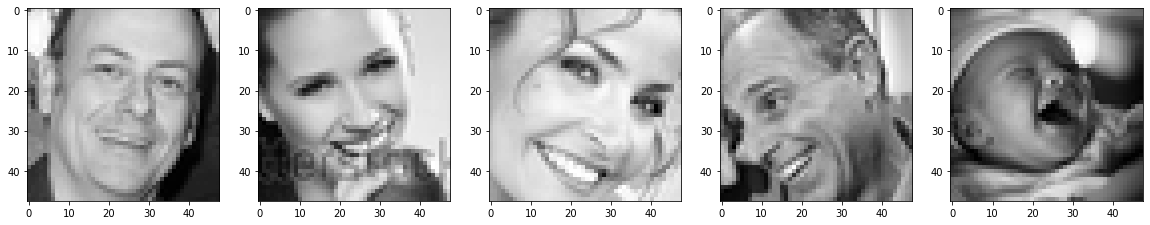

Showing random sample images for Neutral


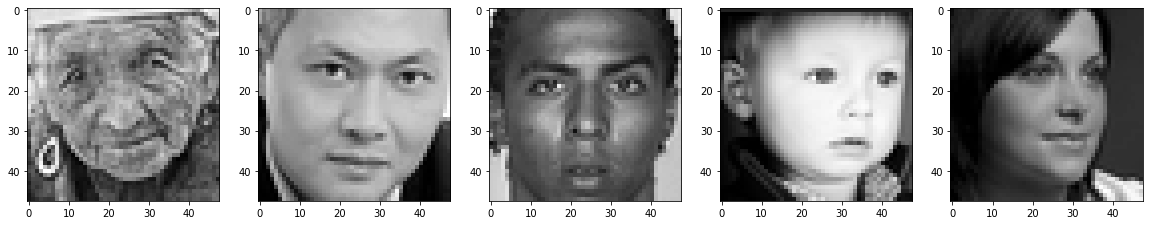

Showing random sample images for Sad


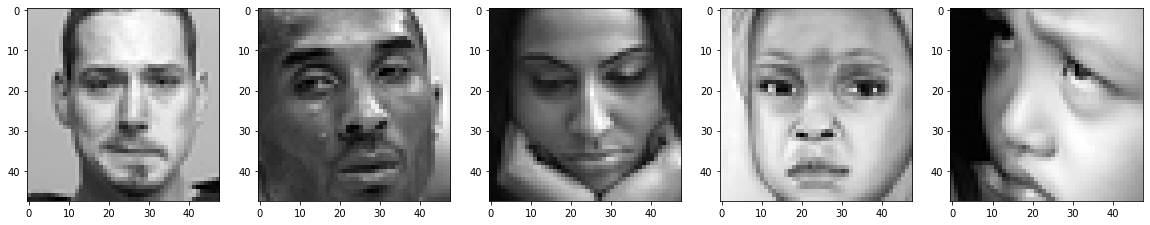

Showing random sample images for Surprise


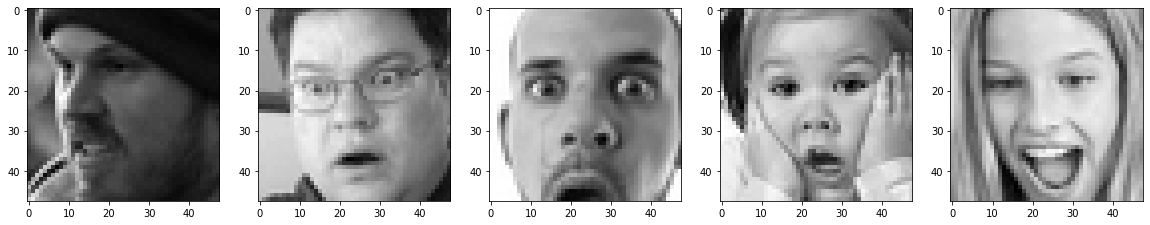

In [113]:
for emotion in sorted(df['emotion_nm'].unique()):
    print(f'Showing random sample images for {emotion}')
    n_sample = 5
    sample_imgs = df[df.emotion_nm == emotion]['pixels_array'].sample(5)
    fig, ax = plt.subplots(1, n_sample, figsize=(20,4))
    for i in range(n_sample):
        ax[i].imshow(sample_imgs.iloc[i], cmap='gray')
    plt.show()

## Emotion
- 'Disgust' has too little samples --> consider removing from model

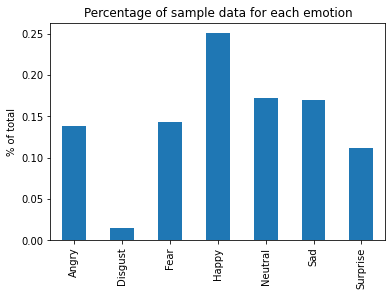

In [68]:
df['emotion_nm'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.ylabel('% of total')
plt.title('Percentage of sample data for each emotion')

plt.show()

## Usage type
- The training set consists of 28,709 examples.
- The public test set used for the leaderboard consists of 3,589 examples.
- The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.

- classes are distributed in the same manner in each usage

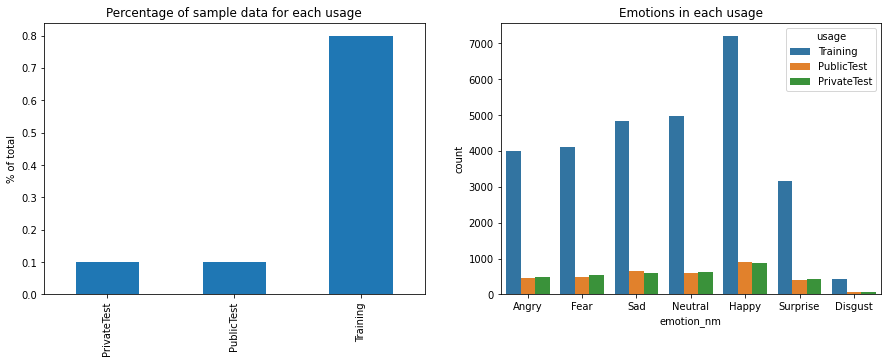

In [71]:
plt.figure(figsize=(15,5))

plt.subplot(121)
df['usage'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.ylabel('% of total')
plt.title('Percentage of sample data for each usage')

plt.subplot(122)
sns.countplot(data=df, x='emotion_nm', hue='usage')
plt.title('Emotions in each usage')

plt.show()

# Data preprocessing

In [50]:
# separate each pixel in pixels array to one column --> to be used as features to try our basic ML models
def pixels_array_to_columns(pixel_array):
    raise NotImplementedError
print(df['pixels_array'][0].dtype)

<U3


In [48]:
pd.DataFrame(df['pixels_array'].apply(np.ravel))

,pixels_array
0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."
...,...
35882,"[50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3..."
35883,"[178, 174, 172, 173, 181, 188, 191, 194, 196, ..."
35884,"[17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2..."
35885,"[30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6..."
